In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.utils import to_categorical
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt

"""Classify 3D radiology images with a neural network.
First simple classification Lung images vs. Prostate images, to develop pipeline. 
Greatly downsampled to fit 3D images on home computer GPU. 
(c) Karl Diedrich 2018 <ktdiedrich@gmail.com>

Monitor GPU with
nvidia-smi stats -d gpuUtil,memUtil
"""

def read_DICOM(dir_path):
    'Read DICOM image from directory'
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( dir_path )
    if len(dicom_names) > 0:
        reader.SetFileNames(dicom_names)
        image = reader.Execute()
        return image
    else:
        return None

def read_DICOMs(rootdir):
    'Read all DICOMs in a directory tree'
    images = list()
    for root, subFolders, files in os.walk(rootdir):
        for subf in subFolders:
            try:
                dir_path = os.path.join(root, subf)
                image = read_DICOM(dir_path=dir_path)
                # if image:
                #    print("Read {}".format(dir_path))
            except:
                pass
                # print("Error reading {}".format(dir_path))
            if image:
                if image.GetSize()[2] > 1:
                    # im_array = sitk.GetArrayFromImage(image)
                    images.append(image)
    return images

def show_slice(im, axis=1, fract=0.5):
    'Show slice along axis at fraction of slice'
    idx = int(im.shape[axis]*fract)
    if axis == 0:
        im_slice = im[idx, :, :]
    elif axis == 1:
        im_slice = im[:, idx, :]
    elif axis == 2:
        im_slice = im[:, :, idx]
    else:
        im_slice = im[idx, :, :]
        
    plt.imshow(im_slice, cmap='gray')
    

Using TensorFlow backend.


In [2]:
# Read in lung cancer images
lung = read_DICOMs(rootdir='/home/ktdiedrich/Documents/localData/RadiologyImages/NSCLCRadiomicsGenomics')
print("Lung N={}".format(len(lung)))

Lung N=89


In [3]:
# read in prostate cancer images
prostate = read_DICOMs(rootdir='/home/ktdiedrich/Documents/localData/RadiologyImages/ProstateFusedMRIPathology')
print("Prostate N={}".format(len(prostate)))

Prostate N=203


In [4]:
# labels
label_name = dict()
label_name[0] = "Lung"
label_name[1] = "Prostate"
lung_labels = [0] * len(lung) 
prostate_labels = [1] * len(prostate)
labels = lung_labels + prostate_labels
print("lung_labels={}, prostate_labels={}, labels={}".format(len(lung_labels), len(prostate_labels),
                                                            len(labels)))

lung_labels=89, prostate_labels=203, labels=292


lung[9] shape=(512, 512, 253)
prostate[3] shape=(256, 256, 22)


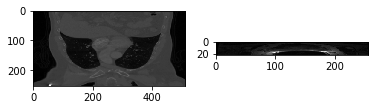

In [5]:
# test view input images
l_idx = 9
p_idx = 3
print("lung[{}] shape={}".format(l_idx, lung[l_idx].GetSize()))
print("prostate[3] shape={}".format(prostate[p_idx].GetSize()))
plt.subplot(1, 2, 1)
show_slice(im=sitk.GetArrayFromImage(lung[l_idx]), axis=1)
plt.subplot(1, 2, 2)
show_slice(im=sitk.GetArrayFromImage(prostate[p_idx]), axis=1)

In [6]:
# check sizes of input images
lung_sizes = [x.GetSize() for x in lung]
prostate_sizes = [x.GetSize() for x in prostate]
print("lung_sizes: {}".format(lung_sizes[0:10]))
print("prostate_sizes: {}".format(prostate_sizes[0:10]))

lung_sizes: [(512, 512, 178), (512, 512, 158), (512, 512, 72), (512, 512, 158), (512, 512, 71), (512, 512, 325), (512, 512, 178), (512, 512, 67), (512, 512, 69), (512, 512, 253)]
prostate_sizes: [(512, 512, 350), (512, 512, 176), (128, 228, 32), (256, 256, 22), (512, 512, 26), (256, 256, 26), (256, 256, 52), (256, 256, 26), (256, 256, 26), (256, 256, 52)]


In [7]:
# check median size 
lung_median = [int(np.median([x.GetSize()[0] for x in lung])),
              int(np.median([x.GetSize()[1] for x in lung])),
              int(np.median([x.GetSize()[2] for x in lung]))]
prostate_median = [int(np.median([x.GetSize()[0] for x in prostate])),
                  int(np.median([x.GetSize()[1] for x in prostate])),
                  int(np.median([x.GetSize()[2] for x in prostate]))]
print("lung_median={}, prostate_median={}".format(lung_median, prostate_median))

lung_median=[512, 512, 157], prostate_median=[256, 256, 33]


In [8]:
def resample_image(itk_image, out_size=[16, 16, 4]):
    """Resample images to new size
    based on https://www.programcreek.com/python/example/96383/SimpleITK.sitkNearestNeighbor 
    """
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    out_spacing = [
        original_spacing[0] * (original_size[0]/out_size[0]),
        original_spacing[1] * (original_size[1]/out_size[1]),
        original_spacing[2] * (original_size[2]/out_size[2])
    ]
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    # resample.SetInterpolator(sitk.sitkNearestNeighbor)
    resample.SetInterpolator(sitk.sitkBSpline)
    return resample.Execute(itk_image)

size=(512, 512, 253) mean=-6.01e+02 sd=4.69e+02 -> size=(4, 16, 16) mean=-5.94e+02 sd=4.74e+02


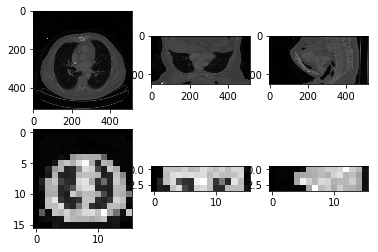

In [9]:
resamp_im = lung[l_idx]
resamp_ar = sitk.GetArrayFromImage(resamp_im)
resampled_im = resample_image(resamp_im)
resampled = sitk.GetArrayFromImage(resampled_im)
print("size={} mean={:.3} sd={:.3} -> size={} mean={:.3} sd={:.3}".format(resamp_im.GetSize(), 
    np.mean(resamp_ar), np.std(resamp_ar), resampled.shape, np.mean(resampled), np.std(resampled) ) )
fract = 0.5
plt.subplot(2, 3, 1)
show_slice(resamp_ar, axis=0, fract=fract)
plt.subplot(2, 3, 2)
show_slice(resamp_ar, axis=1, fract=fract)
plt.subplot(2, 3, 3)
show_slice(resamp_ar, axis=2, fract=fract)
plt.subplot(2, 3, 4)
show_slice(resampled, axis=0, fract=fract)
plt.subplot(2, 3, 5)
show_slice(resampled, axis=1, fract=fract)
plt.subplot(2, 3, 6)
show_slice(resampled, axis=2, fract=fract)

In [10]:
import itertools
arrays = list()
failed_idx = list()
idx = 0
for image in itertools.chain(lung, prostate):
    try:
        resampled = resample_image(image)
        arrays.append(sitk.GetArrayFromImage(resampled))
    except RuntimeError as rune:
        failed_idx.append(idx)
        print(rune)
    finally:
        idx+=1
    

failed: []


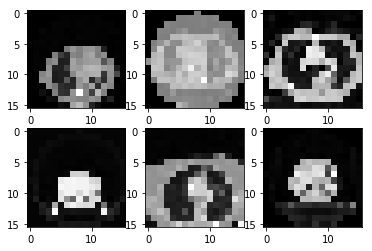

In [11]:
print("failed: {}".format(failed_idx))
# print([ar.shape for ar in arrays])
for idx in range(0, 6):
    plt.subplot(2, 3, idx+1)
    show_slice(arrays[idx], axis=0)

<class 'numpy.ndarray'>
<class 'list'> <class 'list'>
arrays=292, labels=292, label_cats=(292, 2)
(292, 4, 16, 16)
{0: 'Lung', 1: 'Prostate'}
[[0 1 1]
 [1 1 1]
 [1 0 1]]


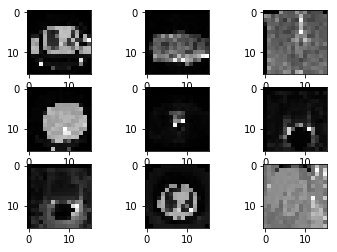

In [12]:
print(type(arrays[0]))
print("{} {}".format(type(arrays), type(labels)))
import random
array_label = list(zip(arrays, labels))
random.shuffle(array_label)
arrays, labels = zip(*array_label)
label_cats = to_categorical(labels)
print("arrays={}, labels={}, label_cats={}".format(len(arrays), len(labels), label_cats.shape))
arrays = np.array(arrays)
print(arrays.shape)
a = 0; b = 9
plot_idx = 1
print(label_name)
print(np.array(labels[a:b]).reshape((3,3))) 
for idx in range(a, b):
    plt.subplot(3, 3, plot_idx)
    show_slice(arrays[idx], axis=0)
    plot_idx+=1

In [13]:
from sklearn import model_selection
max_intensity = np.max(arrays)
norm_arrays = arrays/max_intensity
max_norm = np.max(norm_arrays)
train_images, test_images, train_labels, test_labels = model_selection.train_test_split(norm_arrays, 
                                        label_cats, test_size=0.2, random_state=42)
print("train_images={} train_labels={} test_images={} test_labels={} max_norm={}".format(
    train_images.shape, train_labels.shape, test_images.shape, test_labels.shape, max_norm))

from six.moves import reduce
input_size = reduce(lambda x, y: x*y, train_images.shape[1:train_images.ndim])
train_images = train_images.reshape( 
    train_images.shape[0], input_size).astype('float32')
test_images = test_images.reshape(
    test_images.shape[0], input_size).astype('float32')
print("reshape: train_images={} {}, test_images={} {}".format(
    train_images.shape, train_images.dtype, test_images.shape, test_images.dtype))

train_images=(233, 4, 16, 16) train_labels=(233, 2) test_images=(59, 4, 16, 16) test_labels=(59, 2) max_norm=1.0
reshape: train_images=(233, 1024) float32, test_images=(59, 1024) float32


In [14]:
from keras import models, layers
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(input_size,)))
network.add(layers.Dense(2, activation='softmax'))
network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network.fit(train_images, train_labels, epochs=6, batch_size=18)
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc={:.3}'.format(test_acc))

Epoch 1/6
233/233 [==============================] - 1s 3ms/step - loss: 0.6122 - acc: 0.8970
Epoch 2/6
233/233 [==============================] - 0s 84us/step - loss: 0.4535 - acc: 0.9313
Epoch 3/6
233/233 [==============================] - 0s 80us/step - loss: 0.3674 - acc: 0.9399
Epoch 4/6
233/233 [==============================] - 0s 81us/step - loss: 0.3083 - acc: 0.9399
Epoch 5/6
233/233 [==============================] - 0s 81us/step - loss: 0.2664 - acc: 0.9399
Epoch 6/6
59/59 [==============================] - 0s 385us/step
test_acc=0.949


In [15]:
# monitor GPU with nvidia-smi stats 